In [1]:
import tensorflow as tf
import datetime, os, shutil
from model import *
from model import PredictCallback
from data import *
import splitfolders

In [2]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Initialize the model (U-Net)

In [3]:
model = unet()
# model_checkpoint = ModelCheckpoint('unet_larynx_{epoch:02d}-{loss:.2f}.hdf5', monitor='loss', verbose=1, save_best_only=True)
model_checkpoint = ModelCheckpoint('unet_larynx.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

#### Unpack videos and labels

In [4]:
unpack_video('data/larynx/train', video_folder='video', image_folder='image/glottis', target_size=(256, 256))
unpack_tif('data/larynx/train', tif_folder='tifs', label_folder='label/glottis', target_size=(256, 256))

#### Prepare training dataset

In [6]:
splitfolders.ratio("data/larynx/train/image", output="data/larynx/train/image_split",
    seed=1234, ratio=(.8, .2), group_prefix=None, move=False) 
splitfolders.ratio("data/larynx/train/label", output="data/larynx/train/label_split",
    seed=1234, ratio=(.8, .2), group_prefix=None, move=False) 


Copying files: 6011 files [00:19, 304.30 files/s]
Copying files: 6011 files [00:13, 458.84 files/s]


In [7]:
move_files("data/larynx/train/image_split/train/glottis/", "data/larynx/train/train_dataset/image/")
move_files("data/larynx/train/image_split/val/glottis/", "data/larynx/train/validation_dataset/image/")

move_files("data/larynx/train/label_split/train/glottis/", "data/larynx/train/train_dataset/label/")
move_files("data/larynx/train/label_split/val/glottis/", "data/larynx/train/validation_dataset/label/")

In [4]:

training_dataset = training_dataset_generator(2,
                                              'data/larynx/train/train_dataset/',
                                              'image',
                                              'label',
                                              save_to_dir=None)

val_dataset = training_dataset_generator(2,
                                              'data/larynx/train/validation_dataset/',
                                              'image',
                                              'label',
                                              save_to_dir=None)

In [5]:
# Set up TensorBoard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

path_to_image = 'data\larynx\image_callback'
epoch_predict = PredictCallback(path_to_image)

# Train the model using the training dataset and TensorBoard callback
history = model.fit(training_dataset, 
          steps_per_epoch=100, 
          epochs=5000, 
          callbacks=[model_checkpoint, tensorboard_callback, early_stopping, epoch_predict],
          validation_data=val_dataset,
          validation_steps=100
        )

Found 4808 images belonging to 1 classes.
Found 4808 images belonging to 1 classes.
Epoch 1/5000
  6/100 [>.............................] - ETA: 6s - loss: 0.9091 - dice_coefficient: 0.0909WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0092s vs `on_train_batch_end` time: 0.0543s). Check your callbacks.


100/100 [==============================] - ETA: 0s - loss: 0.9094 - dice_coefficient: 0.0906Found 1203 images belonging to 1 classes.
Found 1203 images belonging to 1 classes.

Epoch 1: val_loss improved from inf to 0.90408, saving model to unet_larynx.hdf5
100/100 [==============================] - 21s 153ms/step - loss: 0.9094 - dice_coefficient: 0.0906 - val_loss: 0.9041 - val_dice_coefficient: 0.0959
Epoch 2/5000
100/100 [==============================] - ETA: 0s - loss: 0.8709 - dice_coefficient: 0.1291
Epoch 2: val_loss improved from 0.90408 to 0.88025, saving model to unet_larynx.hdf5
100/100 [==============================] - 11s 110ms/step - loss: 0.8709 - dice_coefficient: 0.1291 - val_loss: 0.8802 - val_dice_coefficient: 0.1198
Epoch 3/5000
100/100 [==============================] - ETA: 0s - loss: 0.8947 - dice_coefficient: 0.1053
Epoch 3: val_loss did not improve from 0.88025
100/100 [==============================] - 11s 107ms/step - loss: 0.8947 - dice_coefficient: 0.105

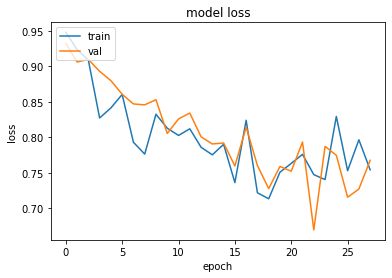

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

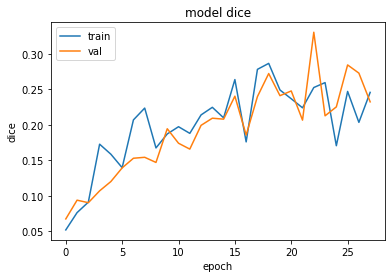

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('model dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Testing the model

In [ ]:
# testing the model
test_dataset = test_dataset_generator("data/larynx/test", num_image=5)
results = model.predict(test_dataset, 3, verbose=1)
saveResult("data/larynx/test", results)


TypeError: test_dataset_generator() got an unexpected keyword argument 'num_image'

In [ ]:
%tensorboard